In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

from utils.train import train, create_dataloader
from models import cVAE

In [2]:
# this center aligns all figures

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Load/Process Data:

The function `create_dataloader` generates a PyTorch dataloader using the given batch size. It loads the input filepath and splits the data into intervals of 100 timesteps. Each split timestep is shifted to form input-output pairs of (t, t+1) images, which are then combined back together.

In [3]:
batch_size = 32 # same batch size for train and val

train_path = 'data/Ferguson_fire_train.npy'
train_loader = create_dataloader(train_path, batch_size)

val_path = 'data/Ferguson_fire_test.npy'
val_loader = create_dataloader(val_path, batch_size, mode='val')

### Train (ConvVAE) Model:

The `train` function trains the model using MSE loss and the Adam optimizer for the specified number of epochs. 

It includes early stopping based on the validation loss, with a default patience of 3.

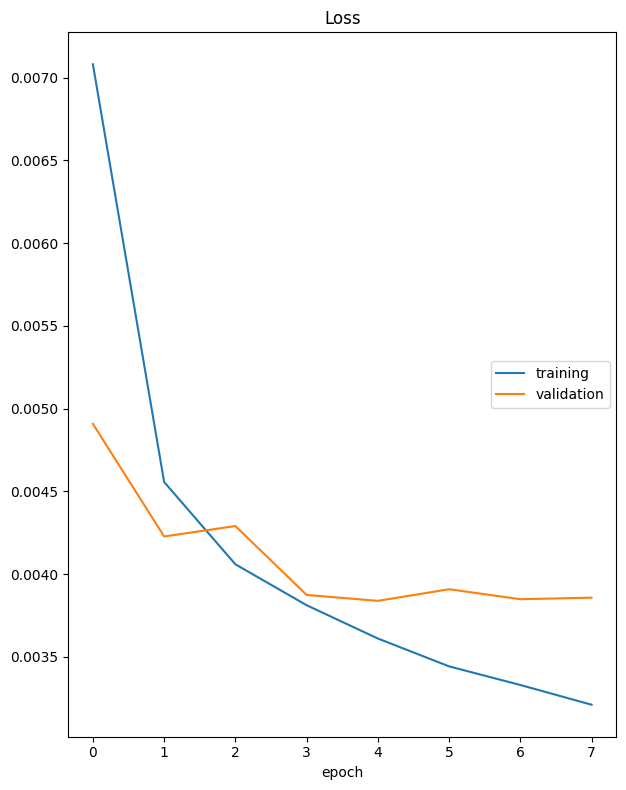

Loss
	training         	 (min:    0.003, max:    0.007, cur:    0.003)
	validation       	 (min:    0.004, max:    0.005, cur:    0.004)
Trained stopped early: No improvement in val loss for 3 epochs.


In [4]:
device = 'cpu'
cvae = cVAE.VAE_Conv(device).to(device)

# loads model from saved weights if found, else trains from scratch
if not os.path.exists('models/weights/cvae.pt'):
    cvae = train(cvae, train_loader, val_loader, epochs=20, device=device)
    if not os.path.exists('models/weights'):
        os.makedirs('models/weights')
    torch.save(cvae.state_dict(), 'models/weights/cvae.pt')
else:
    cvae.load_state_dict(torch.load('models/weights/cvae.pt'))

### Plot validation results (actual vs forecasted):

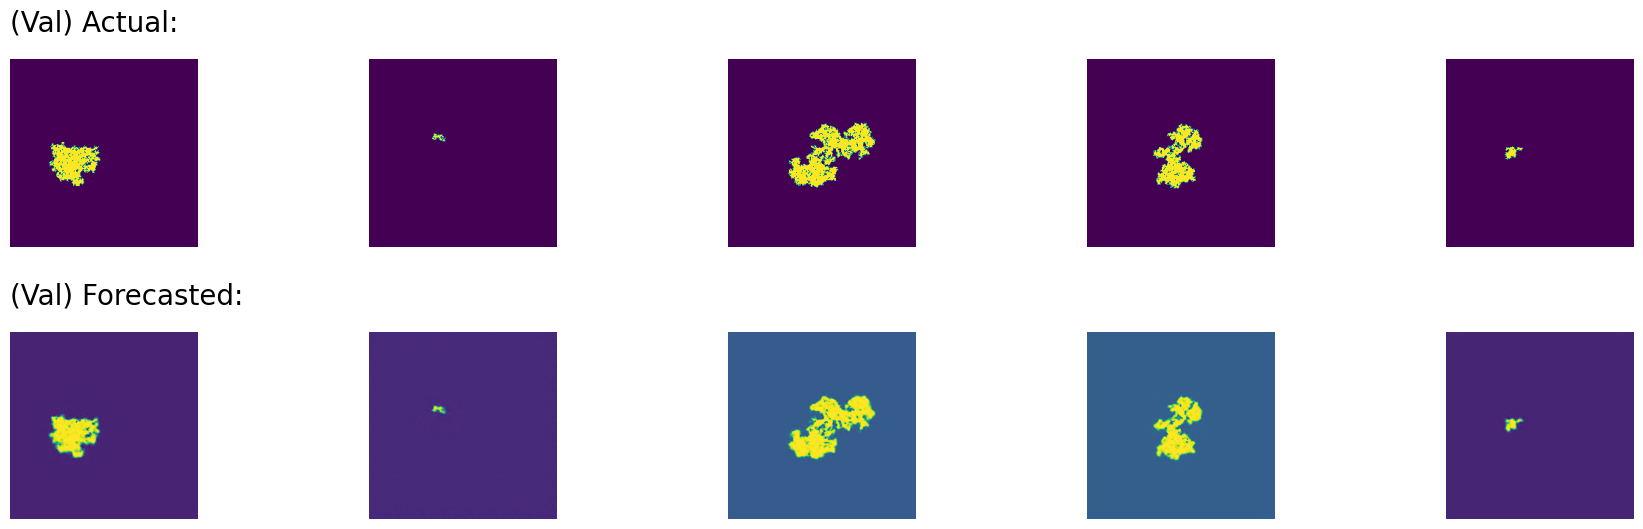

In [5]:
images, labels = next(iter(val_loader))
cvae.eval()

fig, ax = plt.subplots(2, 5, figsize=[18.5, 6])
fig.tight_layout(pad=4)
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
    recon, _ = cvae(images[idx].unsqueeze(0)) 
    ax[0, n].imshow(labels[idx].squeeze(), cmap='OrRd')
    ax[0, n].axis('off')
    ax[1, n].imshow(recon.cpu().detach().squeeze(), cmap='OrRd')
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Val) Actual:', fontsize=15, pad=10, loc='left')
        ax[1,n].set_title('(Val) Forecasted:', fontsize=15, pad=10, loc='left')

### Load test data and plot test results (actual vs forecasted):

In [6]:
# load test (i.e. observation) data

test_path = 'data/Ferguson_fire_obs.npy'
test_data = np.array(np.load(open(test_path,'rb')))
test_data_shifted = torch.Tensor(test_data[1:])
test_data = torch.Tensor(test_data[:-1])
test_dataset = TensorDataset(test_data,test_data_shifted)

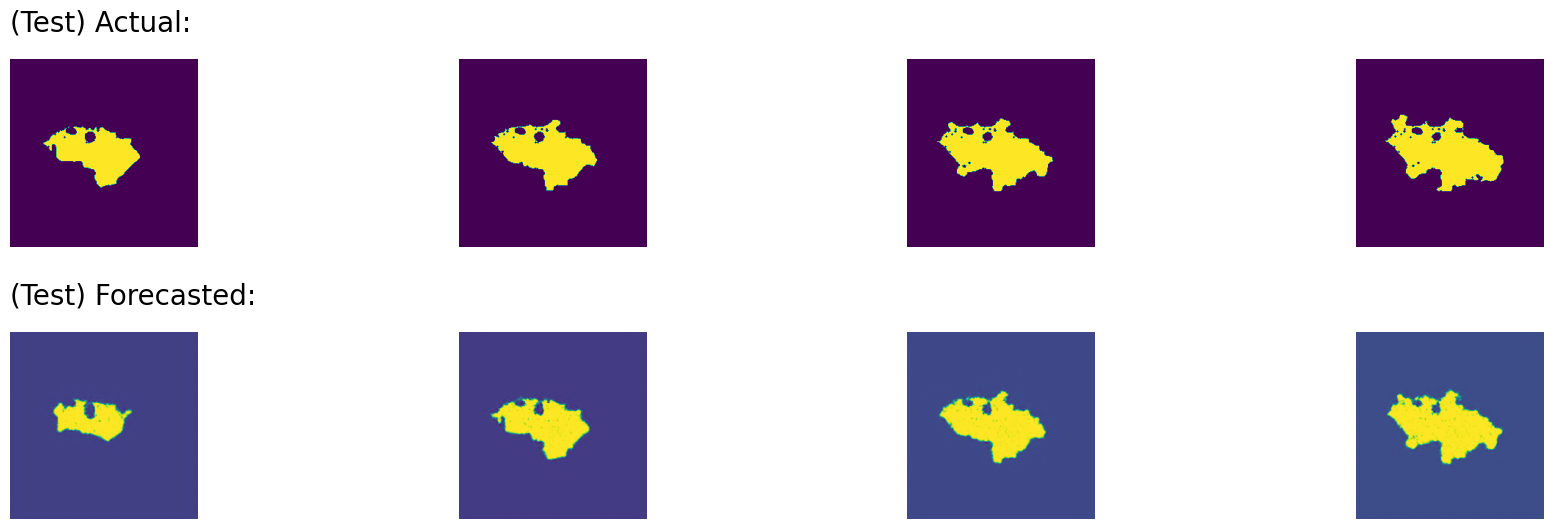

In [7]:
fig, ax = plt.subplots(2, 4, figsize=[18.5, 6])
fig.tight_layout(pad=4)
mses = []
for n,(image,label) in enumerate(test_dataset):
    recon, _ = cvae(image.unsqueeze(0)) 
    mses.append(mean_squared_error(label.flatten(),recon.cpu().detach().squeeze().flatten()))
    ax[0, n].axis('off')
    ax[0, n].imshow(label.squeeze(), cmap='OrRd')
    ax[1, n].imshow(recon.cpu().detach().squeeze(), cmap='OrRd')
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Test) Actual:', fontsize=15, pad=10, loc='left')
        ax[1,n].set_title('(Test) Forecasted:', fontsize=15, pad=10, loc='left')

### Test MSE:

Below is the MSE between the (observed) satellite data and the model's forecasts. 

In [8]:
print(f'(Test) MSE: {sum(mses)/len(test_dataset)}')

(Test) MSE: 0.020040648290887475
